In [4]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
mask_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_msk_20m.asc'
dem_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_dem_20m.asc'
asp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_asp_20m.asc'
slp_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/terrain/tuolumne_slp_20m.asc'

depth_20m_path = '/Users/meganmason491/Documents/research/sierra/data/20m_analysis/ascii/*.asc'
depth_20m_years = list(range(2013, 2019))

In [6]:
flist = glob.glob(depth_20m_path)
flist = sorted(flist)
print('Number of files as input:', len(flist))

flight_dates = []

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    flight_dates.append(dt_str[:-2]) #append to flight_date list

flight_dates_dt = [datetime.strptime(flight_date, '%Y%m%d') for flight_date in flight_dates]

Number of files as input: 51


mask shape: (2738, 2637) 
dem shape: (2738, 2637) 
asp shape: (2738, 2637) 
slp shape: (2738, 2637) 
example lidar shape: (2738, 2637)


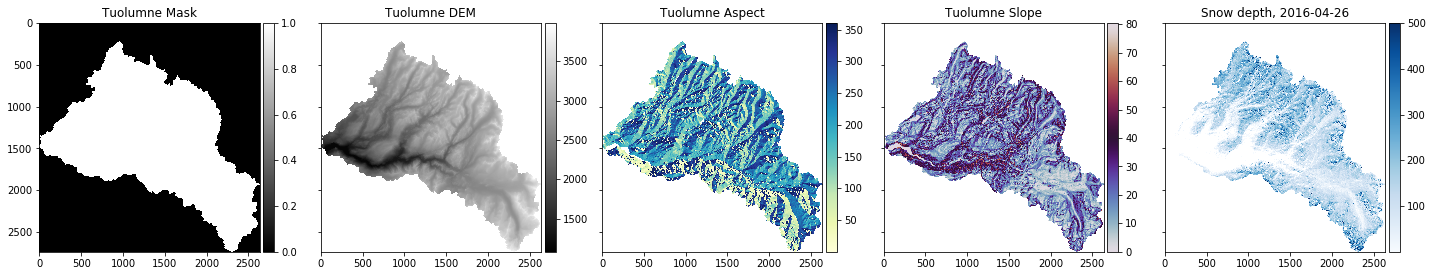

In [7]:
mask_20m = np.loadtxt(mask_20m_path, skiprows=6)
dem_20m = np.loadtxt(dem_20m_path, skiprows=6)
asp_20m = np.loadtxt(asp_20m_path, skiprows=7) #hack to make #rows same size....
slp_20m = np.loadtxt(slp_20m_path, skiprows=7) #hack to make #rows same size....
ex_depth = np.loadtxt(flist[31], skiprows=7) / 10 #mm to cm, #hack to make #rows same size....

print('mask shape:', mask_20m.shape, 
      '\ndem shape:', dem_20m.shape,
      '\nasp shape:', asp_20m.shape,
      '\nslp shape:', slp_20m.shape,
      '\nexample lidar shape:', ex_depth.shape)

# print('\nmask type:', type(mask_20m), 
#       '\ndem type:', type(dem_20m), 
#       '\nasp type:', type(asp_20m),
#       '\nslp type:', type(slp_20m),
#       '\nexample lidar type:', type(ex_depth))



f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,6))
#mask
im1 = ax1.imshow(mask_20m, cmap='gray')
ax1.set_title('Tuolumne Mask')
divider = make_axes_locatable(ax1)
plt.colorbar(im1, cax=divider.append_axes("right", size="5%", pad=0.05))
#dem
dem_20m[mask_20m==0]=np.nan
im2 = ax2.imshow(dem_20m, cmap='gray')
ax2.set_title('Tuolumne DEM')
divider = make_axes_locatable(ax2)
plt.colorbar(im2, cax=divider.append_axes("right", size="5%", pad=0.05))
#aspect
asp_20m[asp_20m<=0]=np.nan
asp_20m[mask_20m==0]=np.nan
im3 = ax3.imshow(asp_20m, cmap='YlGnBu')
ax3.set_title('Tuolumne Aspect')
divider = make_axes_locatable(ax3)
plt.colorbar(im3, cax=divider.append_axes("right", size="5%", pad=0.05))
#slope
slp_20m[mask_20m==0]=np.nan
im4 = ax4.imshow(slp_20m, cmap='twilight')
ax4.set_title('Tuolumne Slope')
divider = make_axes_locatable(ax4)
plt.colorbar(im4, cax=divider.append_axes("right", size="5%", pad=0.05))
#snow depth, 1 of 51
ex_depth[ex_depth<=0]=np.nan
ex_depth[mask_20m==0]=np.nan
im5 = ax5.imshow(ex_depth, cmap='Blues', vmax=500) 
ax5.set_title('Snow depth, {}'.format(flight_dates_dt[31].date())) 
divider = make_axes_locatable(ax5) 
plt.colorbar(im5, cax=divider.append_axes("right", size="5%", pad=0.05))

plt.tight_layout()

In [6]:
flight_period = {}
for year in range(2013,2019):

    flight_period[year] = [flight_dates_dt[i_date+1] - flight_dates_dt[i_date] 
                           for i_date in range(len(flight_dates_dt)-1) 
                           if (year == flight_dates_dt[i_date+1].year) & (year == flight_dates_dt[i_date].year)]
    
    print('frequencies for {}: {} - {} days'.format(year, min(flight_period[year]).days, max(flight_period[year]).days))

frequencies for 2013: 4 - 26 days
frequencies for 2014: 4 - 15 days
frequencies for 2015: 4 - 27 days
frequencies for 2016: 5 - 18 days
frequencies for 2017: 8 - 35 days
frequencies for 2018: 35 - 35 days


### Tuolumne Basin Mean Snow Depth 

In [8]:
# ~~ Function 1, mean snow depth
def mean_snow_depth(depth_array, convert_factor = 1e-3, dem_array = None, dem_value = None, mask_array = None, mask_value = None):
    '''
    Gets mean snow depth for ASO snow depth surfaces
        args:
            depth_array: numpy array from asc files
            dem_array: 
            dx: cellsize [m] in x direction
            dy: cellsize [m] in y direction
            convert_factor: (optional, default is 0.001 from mm to m)
            mask_array: (Optional) mask of the area for depth calculation
                       If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                       Default value will be any positive integer
           Note: depth_array and mask_array should cover the same extent 
                 and have the same dx,dy
       return:
           mean_depth: mean depth [m] over the area in mask
                       or the full area in the array if no mask is provided
    '''
    
    depth_array = depth_array/1000 #convert mm to m
    
    
    if dem_array is None: #full basin
    
        if mask_array is None:
            mean_depth = np.nanmean(depth_array[(depth_array > 0)])
            sca = depth_array[(depth_array > 0)].size / mask_array[mask_array == mask_value].size

        else:
            mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0)]])
            sca = (depth_array[[(mask_array == mask_value) & (depth_array > 0)]].size / mask_array[mask_array == mask_value].size) * 100
    
    
    else: #elevation filter (commonly use 2000m to avoid rain-snow)
        
        if mask_array is None:
            mean_depth = np.nanmean(depth_array[(depth_array > 0) & depth_array[dem_array>=dem_value]])
            sca = depth_array[(depth_array > 0)].size / mask_array[mask_array == mask_value].size

        else:
            mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0) & (dem_array >= dem_value)]])
            sca = (depth_array[[(mask_array == mask_value) & (depth_array > 0) & (dem_array >= dem_value)]].size / mask_array[mask_array == mask_value].size) * 100
    
        

    return mean_depth, sca

In [9]:
# call Function 1
mean_depth = []
sca = []

for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=7) #load asc files    
    mean_d, sca_ = mean_snow_depth(depth_array, dem_array=dem_20m, dem_value=2000, mask_array=mask_20m, mask_value=np.max(mask_20m)) #call mean_snow_depth function
    mean_depth.append(mean_d)
    sca.append(sca_)

# mean_depth_df = pd.DataFrame(data = mean_depths, index = flight_dates_dt, columns = ['mean_snow_depth'])
# sca_df = pd.DataFrame(data = sca, index = flight_dates_dt, columns = ['sca'])

df = pd.DataFrame(zip(mean_depth, sca), columns = ['meanSD (m)','SCA (%)'], index = flight_dates_dt)
# df

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result

In [10]:
# ~~ Function 2, peak mean snow depth per year
def get_peak(datetime_list, series_list, years):
    '''
    Calculates yearly peak mean depth
    input:
        datetime_list: list containing the datetime stamps for the time series
        series_list: list with the time series of mean depth values
        years: list with years to analyze
    return:
        peak_df: yearly peak value dataframe with datetime_peak as index and peak value in column
    '''
    

    df_series = pd.DataFrame(data = series_list, index = datetime_list, columns = ['series'])
    
    for year in years:
        df_year = df_series.truncate(before = str(year) + '-01', after = str(year) + '-12')
        if year == years[0]:
            peak_df = pd.DataFrame(data = [df_year.max(axis = 0).values[0]], index = [df_year.idxmax(axis = 0).values[0]], columns = ['peak mean depth'])
        else:
            peak_df.loc[df_year.idxmax(axis = 0).values[0]] = df_year.max(axis = 0).values[0]
            
    return peak_df


In [11]:
# call Function 2

# peak mean depths
peak_mean_depth_df = get_peak(flight_dates_dt, mean_depth, depth_20m_years)
 
#peak sca
peak_sca_df = get_peak(flight_dates_dt, sca, depth_20m_years)
# peak_sca_df

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


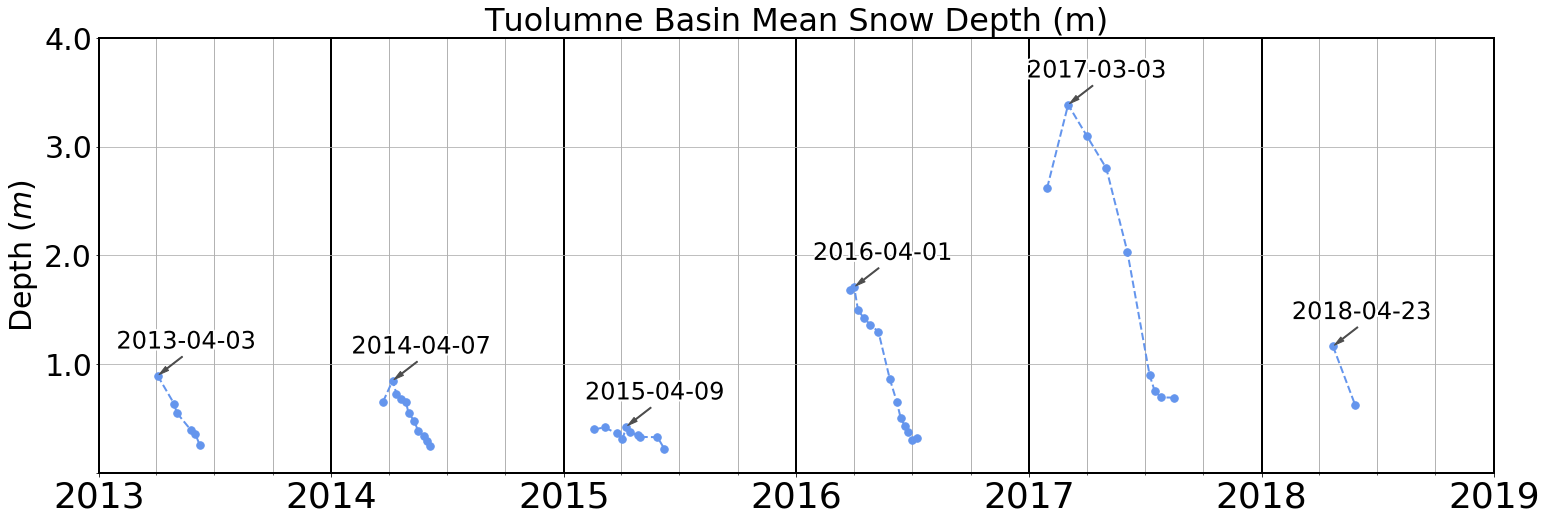

In [14]:
#~~~~use:
# df['meanSD (m)'] (func 1)
# peak_mean_depth_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(25,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_20m_years: #(list(range(2013,2019)))
    depth_year = df['meanSD (m)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='.', markersize=15, color='cornflowerblue', linestyle = '--', linewidth = '2')
    
    h_text_date = plt.annotate(str(peak_mean_depth_df.index[i_plot])[:10], xy=(peak_mean_depth_df.index[i_plot], peak_mean_depth_df.iloc[i_plot]), 
                               xytext=(peak_mean_depth_df.index[i_plot]+pd.Timedelta('45 days'), peak_mean_depth_df.iloc[i_plot] + 0.25),
                               arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                               fontsize = fs_text-2, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Mean Snow Depth (m)', fontsize = fs_titles)
plt.ylabel('Depth $(m)$',fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+6)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+2)    # fontsize of the tick labels
plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=1)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2019-01-01')])

y_ticks = np.array(list(range(0, 45, 10)))/10
y_ticklabels = [str(y_tick) for y_tick in y_ticks]
y_ticklabels[0] = ''
plt.yticks(y_ticks, y_ticklabels)

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

plt.savefig('../figs/basin_mean_snow_depth.png', dpi=300)
# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/20m_depth/mean_snow_depth.png', dpi=300)

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


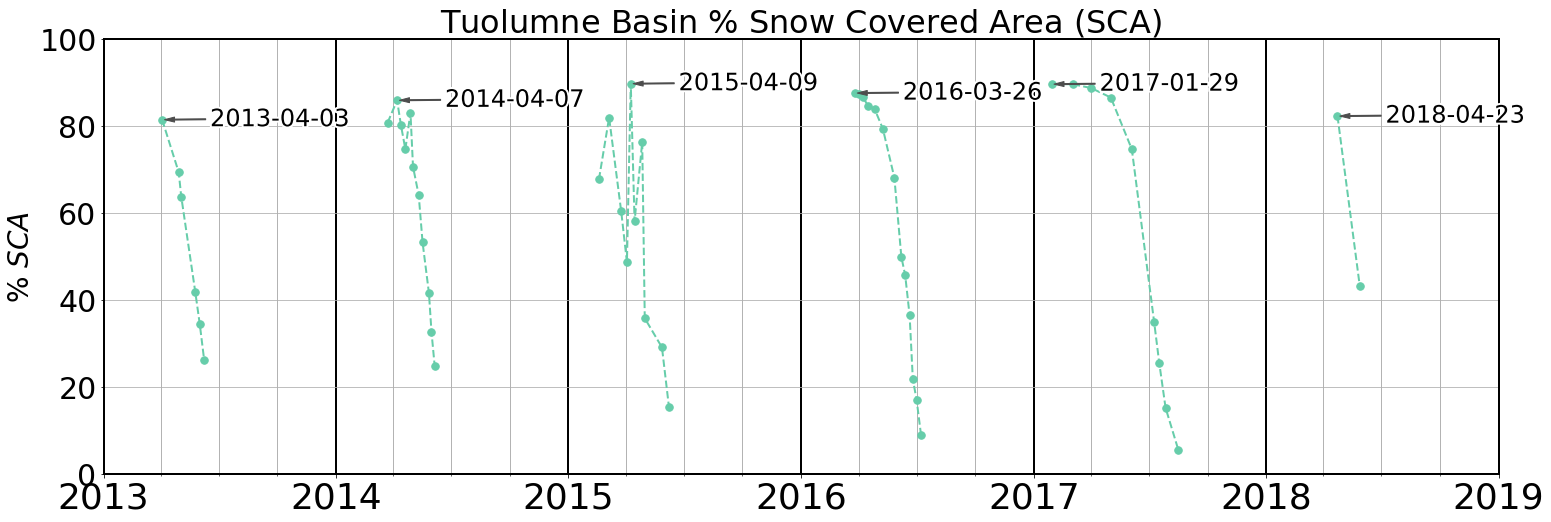

In [17]:
#use:
# df['SCA (%)'] (func 1)
# peak_sca_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(25,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_20m_years: #(list(range(2013,2018)))
    depth_year = df['SCA (%)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='.', markersize=15, color='mediumaquamarine', linestyle = '--', linewidth = '2')
    
    h_text_date = plt.annotate(str(peak_sca_df.index[i_plot])[:10], xy=(peak_sca_df.index[i_plot], peak_sca_df.iloc[i_plot]), 
                               xytext=(peak_sca_df.index[i_plot]+pd.Timedelta('185 days'), peak_sca_df.iloc[i_plot] - 1.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text-2, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin $\%$ Snow Covered Area (SCA)', fontsize = fs_titles)
plt.ylabel('$\%$ $SCA$', fontsize = fs_labels + 2)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
plt.ylim([0, 100])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=1)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2019-01-01')])

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

plt.savefig('../figs/basin_sca.png', dpi=300)
# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/20m_depth/sca_depth.png', dpi=300)

In [12]:
#skipping max depth thing...
#skipping HISTOGRAM section for now.....

## Time for elevation bands !
Consider where the depth is within the basin

In [13]:
def mean_sd_band(depth_array, elev_array, min_elev, max_elev, mask_array= None, mask_value= None):
   
    '''
    This method computes the mean snow depth for different elevation bands 
    
        args:
            depth_array: np array of snow depths, [cm]
            elev_array: dem of basin, extent matches depth_array, [m]
            min_elev: lower limit of elevation band (inclusive)
            max_elev: upper limit of elevation band (exclusive)
            mask_array: (Optional) mask of the area for SWE calculation
                         If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                        Default value will be any positive integer
        
        returns: mean depth at each elevation band, np float
            
    '''
    
    if mask_array is None:
        mean_depth_band = np.nanmean([depth_array[(elev_array >= min_elev) & (elev_array < max_elev)]])
    
    else:
        depth_array = depth_array[(mask_array == mask_value)]
        elev_array = elev_array[mask_array == mask_value]
        depth_at_bands = depth_array[(elev_array >= min_elev) & (elev_array < max_elev)]
        mean_depth_band = np.nanmean(depth_at_bands[depth_at_bands > 0])
        
    return mean_depth_band

In [98]:
elev_sd_df = pd.DataFrame()

band_width = 250
lower_limits = list(range(1500,4000, band_width))
upper_limits = list(range(1750,4250, band_width))


for i, flight_date_dt in enumerate(flight_dates_dt):
    
    depth_array = np.loadtxt(flist[i], skiprows=7) / 10 #load lidar files, [cm]
    date_key = {'flight_date': flight_date_dt} #dict, key is flight date
    
    for lower_limit in lower_limits:
    
        mean_sd = mean_sd_band(depth_array, dem_20m, lower_limit, lower_limit + band_width, mask_20m, mask_value=np.max(mask_20m)) #get mean for each elevation band
        date_key[lower_limit] = mean_sd #store mean at each band for every flight date
    
    elev_sd_df = elev_sd_df.append(date_key, ignore_index=True)
    
elev_sd_df.set_index('flight_date', inplace=True)

# export_csv = elev_sd_df.to_csv('/home/meganmason/Documents/projects/thesis/figures/tables/elev_sd_df.csv', index = True, header=True) #ind=T stores row names
# elev_sd_df

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


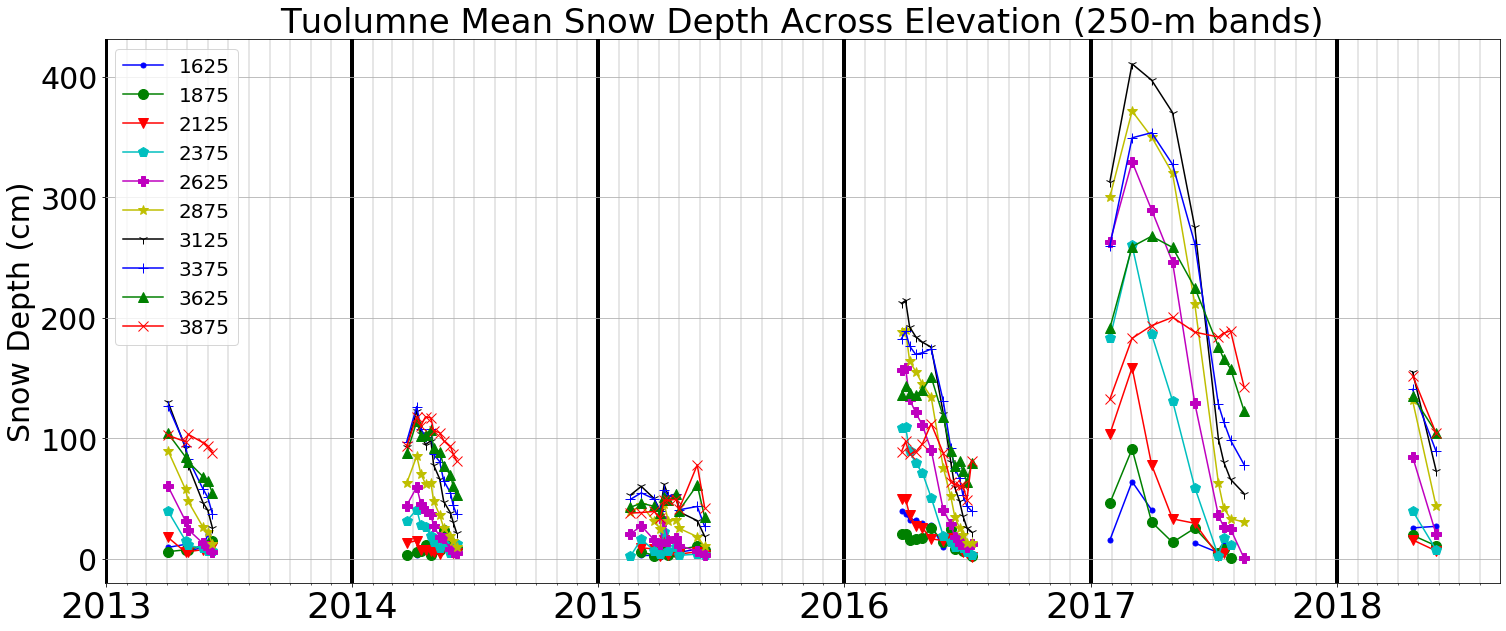

In [99]:
# LEGEND NEEDS ELEVATION BAND, not middle

#method
    #1). iterate elevation bands, store in mini dfs (first loop)
    #2). split by years, and add to figure (second loop) - (i.e plot blue 1625 line for each year, loop back to next elevation band) 

color_count = 0
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
markers = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x']
minorLocator = MultipleLocator(365/2)

plt.figure(figsize = (25, 10))
    
for idx, depth_band in elev_sd_df.items():

    color_band = colors[color_count]
    maker_band = markers[color_count]
    color_count += 1

    for year in depth_20m_years:

        if year == 2013:
            depth_year = depth_band.truncate(before = str(year) + '-01', after = str(year) + '-12') #breaks up all the years
            h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False, label=int(idx+band_width/2))
            plt.setp(h_plot, marker = maker_band, markersize = 10, color = color_band, linestyle = '-', linewidth = '1.5')

        else:
            depth_year = depth_band.truncate(before = str(year) + '-01', after = str(year) + '-12') #breaks up all the years
            h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
            plt.setp(h_plot, marker = maker_band, markersize = 10, color = color_band, linestyle = '-', linewidth = '1.5')

plt.title('Tuolumne Mean Snow Depth Across Elevation (250-m bands)', fontsize = fs_titles)
plt.ylabel('Snow Depth (cm)',fontsize = fs_labels)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13)))
# plt.axes().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=4)
plt.grid(axis='x', color=(0.9, 0.9, 0.9), which='minor', linestyle='-', linewidth=2)

plt.rc('legend', fontsize = fs_legend-10)
plt.legend(loc='upper left')
# plt.savefig('../figs/elev_bands_sd_with_markers.png', dpi=300)

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


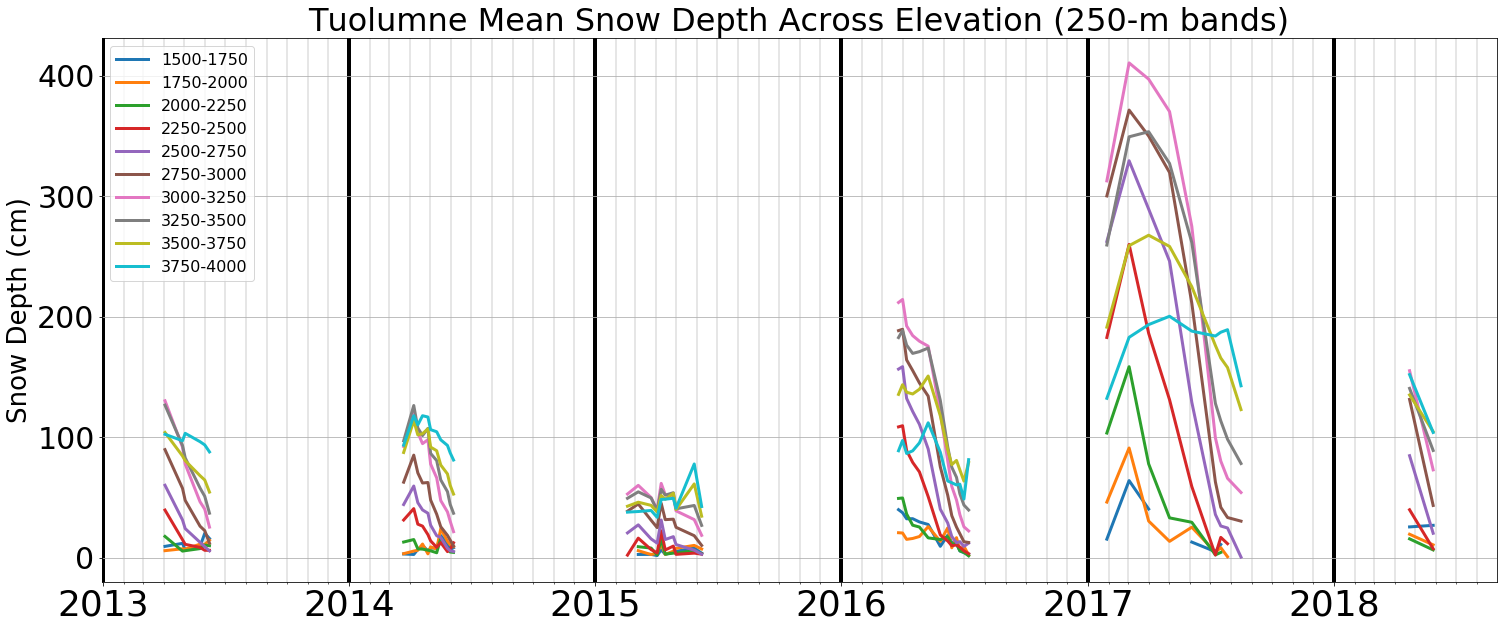

In [16]:
## needs improvement
plt.figure(figsize = (25, 10))

for year in depth_20m_years:
    depth_plot = elev_sd_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
#     h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False, label=int(lower_limits+band_width/2))
#     h_plot = plt.plot_date(elev_sd_df.index, elev_sd_df.values, fmt='x', tz=None, xdate=True, ydate=False)#, label=int(lower_limits+band_width/2))
#     plt.setp(h_plot) #, marker = maker_band, markersize = 10, color = color_band, linestyle = '-', linewidth = '2')
    plt.plot(depth_plot, linewidth=3)
    plt.grid(True, which='both')
    
    plt.title('Tuolumne Mean Snow Depth Across Elevation (250-m bands)', fontsize = fs_titles)
    plt.ylabel('Snow Depth (cm)',fontsize = fs_labels)
    plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13)))
#     plt.axes().xaxis.set_major_locator(mdates.YearLocator())
    plt.grid(True)
    plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=4)
    plt.grid(axis='x', color=(0.9, 0.9, 0.9), which='minor', linestyle='-', linewidth=2)

plt.legend(['1500-1750', '1750-2000', '2000-2250','2250-2500', '2500-2750','2750-3000', '3000-3250', '3250-3500','3500-3750', '3750-4000'], loc='upper left')
# elev_sd_df
# plt.savefig('../figs/elev_bands_sd.png', dpi=150)

In [95]:
# #one plot per elevation band
# color_count = 1
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
# markers = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x']

# for idx, depth_band in elev_sd_df.items(): #iterate bands (columns) in elev dataframe
    
#     plt.figure(figsize = (25, 6))
    
#     color_band = colors[color_count-1]
#     maker_band = markers[color_count-1]
#     color_count += 1

#     depth_band_peak = get_peak(flight_dates_dt, depth_band.values, depth_20m_years)
#     depth_band_df = pd.DataFrame(data = depth_band, index = flight_dates_dt, columns = ['depth_band'])

#     i_plot = 0
    
#     for year in depth_20m_years: # truncate by year
        
#         if year == 2013: #grabs elevation band label
#             depth_year = depth_band.truncate(before = str(year) + '-01', after = str(year) + '-12') #breaks up all the years
#             h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False, label=int(idx+band_width/2))
#             plt.setp(h_plot, marker = '.', markersize = 10, color = color_band, linestyle = '-', linewidth = '2')

#         else:
#             depth_year = depth_band.truncate(before = str(year) + '-01', after = str(year) + '-12') #breaks up all the years
#             h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
#             plt.setp(h_plot, marker = '.', markersize = 10, color = color_band, linestyle = '-', linewidth = '2')  
            
#         plt.annotate(str(depth_band_peak.index[i_plot])[:10], xy=(depth_band_peak.index[i_plot], depth_band_peak.iloc[i_plot]), 
#                     xytext=(depth_band_peak.index[i_plot], depth_band_peak.iloc[i_plot]+50),
#                     arrowprops=dict(shrink=0.01, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
#                     fontsize = fs_text)
        
#         i_plot += 1
            
#     plt.title('Tuolumne Depth Across Elevation (250-m bands)', fontsize = fs_titles)
#     plt.ylabel('Depth, (cm)',fontsize = fs_labels)
#     plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13)))
#     plt.axes().xaxis.set_major_locator(mdates.YearLocator())
#     plt.ylim([0, 450])
#     plt.grid(True)
#     plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=4)
#     plt.grid(axis='x', color=(0.9, 0.9, 0.9), which='minor', linestyle='-', linewidth=2)
#     plt.legend(loc=('upper left'), fontsize=fs_labels-8)
#     plt.rc('legend', fontsize = fs_legend) 
# #     plt.savefig('../figs/elev_bands_{}.png'.format(int(idx+band_width/2)), dpi=150)


In [96]:
elev_sd_df.head()

,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750
flight_date,,,,,,,,,,
2013-04-03,9.461657,5.914827,17.724220,39.584142,60.169010,89.716680,130.242413,126.651336,103.988436,102.442152
2013-04-29,11.983085,7.466086,5.543172,14.996553,31.388105,57.589281,91.803099,93.213237,84.445279,97.083281
2013-05-03,6.527628,7.212112,5.899227,11.157174,24.211532,47.596539,77.666116,82.912310,80.524103,103.240078
2013-05-25,9.348223,11.288000,7.619113,8.600914,12.819443,26.208432,46.454045,57.853583,68.112963,96.304555
2013-06-01,20.347222,11.100403,10.555716,6.214488,9.197572,22.490906,40.304835,50.988384,64.511729,93.621719


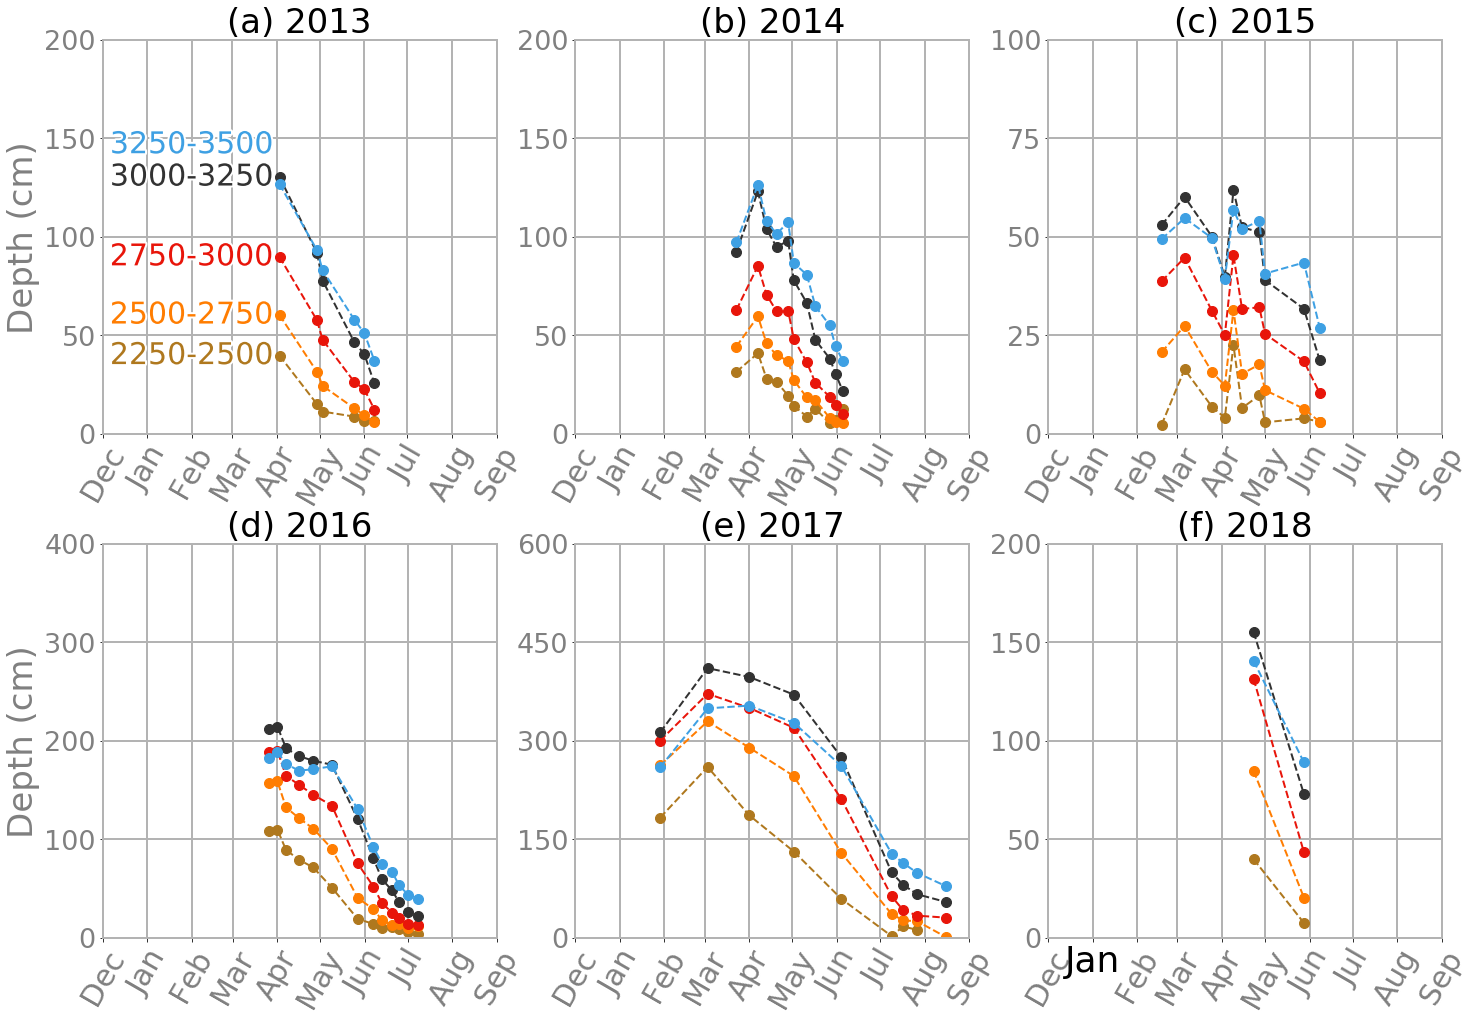

In [100]:
# plot mean snow depth at 250m elevation bands

# area_250m_elev_bands = {lower_limit:0 for lower_limit in lower_limits}

#set up

fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

title_letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
marker = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x']

colors = [(175/255, 120/255, 30/255),
          (255/255, 125/255, 1/255), 
          (232/255, 21/255, 10/255),
          (50/255, 50/255, 50/255),
          (62/255, 160/255, 227/255)]

color_grey = 0.8
grey_text_intensity = 0.5
color_grey_grid = 0.7
color_taf = (color_grey, color_grey, color_grey)
color_grid = (color_grey_grid, color_grey_grid, color_grey_grid)
color_month = (color_grey, color_grey, color_grey)
color_grey_text = (grey_text_intensity, grey_text_intensity, grey_text_intensity)
letter_count = 0

plt.figure(figsize = (24, 17))

i_plot = 1

for year in depth_20m_years:

    ax = plt.subplot(2,3,i_plot)
    
    depth_plot = elev_sd_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
    
    color_count = 0
    max_plot = 0
    
    for lower_limit in lower_limits[3:-2]:
        
        color_band = colors[color_count]
        maker_band = marker[color_count]
        color_count += 1      
        
    
        plt.plot_date(depth_plot.index, depth_plot[lower_limit],
                      fmt='-', tz=None, xdate=True, ydate=False, label=int(lower_limit+band_width/2),
                      color = color_band, linestyle = '--', linewidth = '2', marker = 'o', 
                      markersize = 10, markerfacecolor = color_band)
        
        max_plot = max(max_plot, depth_plot[lower_limit].max())
        str_legend = str(int(lower_limit)) + '-' + str(int(lower_limit + band_width))
    
        
        if year == 2013:
            
            if str_legend == '3250-3500': #different than ET's otherwise str_legend will overlap, +20 on y-axis
                 h_text = plt.text(depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0] +20, str_legend, 
                                   color = color_band, fontsize = fs_legend,
                                   horizontalalignment = 'right', verticalalignment = 'center')
            else:
            
                h_text = plt.text(depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0], str_legend,
                                  color = color_band, fontsize = fs_legend, 
                                  horizontalalignment = 'right', verticalalignment = 'center')
                
            h_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        

    plt.title(title_letter[letter_count] + ' ' + str(year), fontsize = fs_titles)
    letter_count += 1

    if year in [2013, 2016]:
        plt.ylabel('Depth (cm)',fontsize = fs_labels+4, color = color_grey_text)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(fontsize = fs_axes, rotation = 60, horizontalalignment = 'center', color = color_grey_text)
    
    
    if year in [2014, 2015]:
        max_y = np.ceil(max_plot / 100) * 100
        
    else:
        max_y = np.ceil(max_plot / 200) * 200
        
    y_step = int(max_y / 4)
    y_ticks_marks = np.array(list(range(5))) * y_step
    y_ticks_labels = y_ticks_marks
    plt.ylim([0, max_y])
    plt.yticks(y_ticks_marks, y_ticks_labels.astype(int), fontsize = fs_axes-3, color = color_grey_text)
    plt.xlim([pd.to_datetime(str(year-1) + '-12-01'), pd.to_datetime(str(year) + '-09-01')])
    plt.grid(True)
    plt.grid(axis='both', color = color_grid, which = 'major', linestyle = '-', linewidth=2)
    
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['top'].set_color(color_grid)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['bottom'].set_color(color_grid)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['left'].set_color(color_grid)
    ax.spines['right'].set_linewidth(2.0)
    ax.spines['right'].set_color(color_grid)
    
    ratio = 1.0
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)        
        
    
    i_plot += 1
    
plt.savefig('../figs/elv_bins_2250_to_3500.png', dpi=300) 

### SLOPE BINS

In [89]:
slpe_sd_df = pd.DataFrame()

band_width = 15
lower_limits = list(range(0,80, band_width))
upper_limits = list(range(10,90, band_width))


for i, flight_date_dt in enumerate(flight_dates_dt):
    
    depth_array = np.loadtxt(flist[i], skiprows=7) / 10 #load lidar files, [cm]
    date_key = {'flight_date': flight_date_dt} #dict, key is flight date
    
    for lower_limit in lower_limits:
    
        mean_sd = mean_sd_band(depth_array, slp_20m, lower_limit, lower_limit + band_width, mask_20m, mask_value=np.max(mask_20m)) #get mean for each elevation band
        date_key[lower_limit] = mean_sd #store mean at each band for every flight date
    
    slpe_sd_df = slpe_sd_df.append(date_key, ignore_index=True)
    
slpe_sd_df.set_index('flight_date', inplace=True)

# export_csv = slpe_sd_df.to_csv('/home/meganmason/Documents/projects/thesis/figures/tables/slpe_sd_df.csv', index = True, header=True) #ind=T stores row names
#slpe_sd_df

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


In [90]:
slpe_sd_df.head()

,0,15,30,45,60,75
flight_date,,,,,,
2013-04-03,84.736465,97.750877,85.296206,55.839092,39.851422,22.826316
2013-04-29,57.123430,71.645663,64.204753,44.513277,35.325465,24.472727
2013-05-03,49.582141,62.539185,56.060851,38.638385,31.263172,41.463158
2013-05-25,32.294210,46.027726,42.551272,33.163966,29.912415,13.614286
2013-06-01,27.522109,42.366740,39.985012,32.173536,29.650103,0.416667


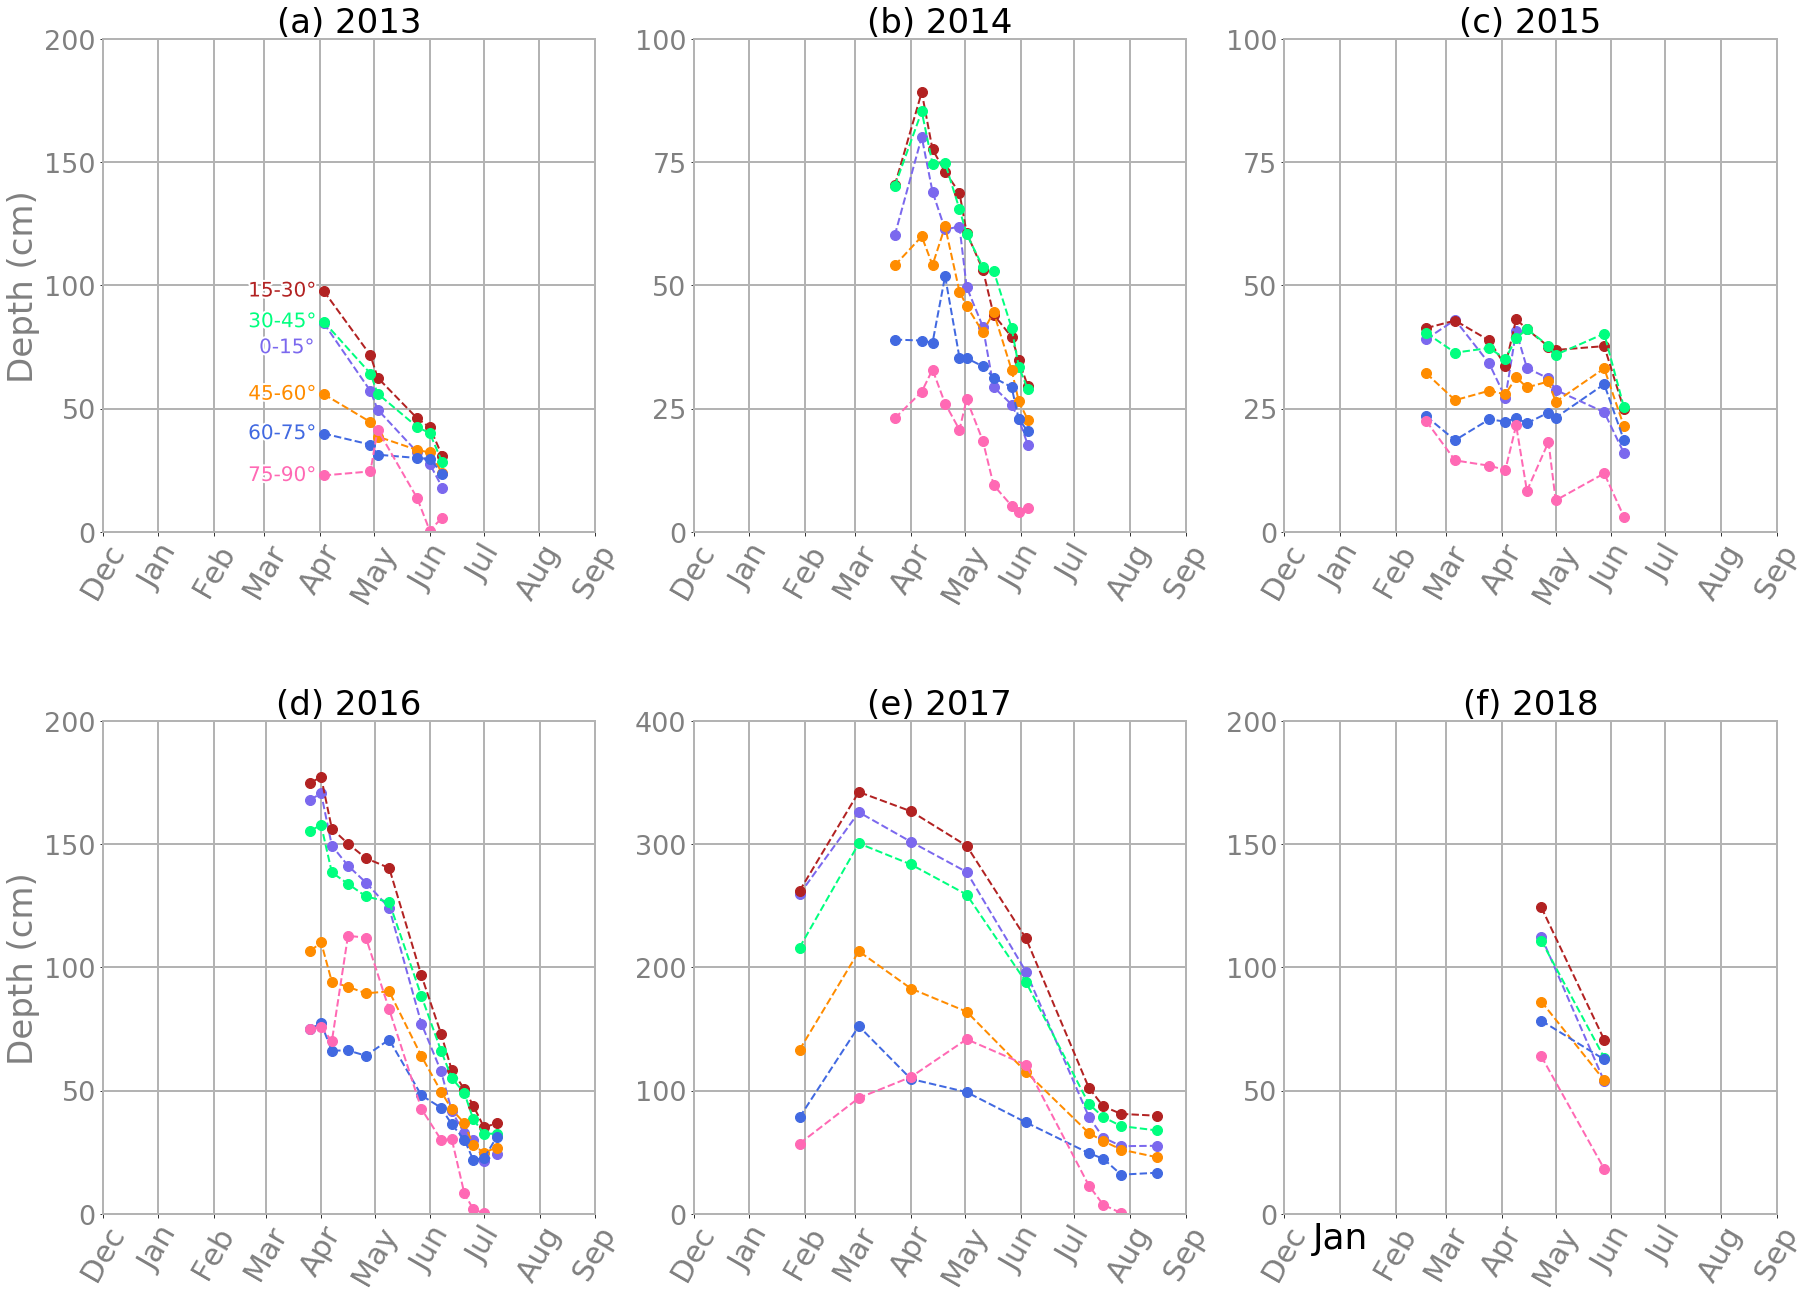

In [92]:
# plot mean snow depth at 10 degree slope bands

# area_250m_elev_bands = {lower_limit:0 for lower_limit in lower_limits}

#set up

fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

title_letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
marker = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x', '.', 'o', 'v', 'p', 'P', '*']
colors = ['b','g','r','c','m','y','b','lime','tan','sienna','mediumslateblue','firebrick','springgreen', 'darkorange','royalblue','hotpink']
# colors = [(175/255, 120/255, 30/255),
#           (255/255, 125/255, 1/255), 
#           (232/255, 21/255, 10/255),
#           (50/255, 50/255, 50/255),
#           (62/255, 160/255, 227/255)]

color_grey = 0.8
grey_text_intensity = 0.5
color_grey_grid = 0.7
color_taf = (color_grey, color_grey, color_grey)
color_grid = (color_grey_grid, color_grey_grid, color_grey_grid)
color_month = (color_grey, color_grey, color_grey)
color_grey_text = (grey_text_intensity, grey_text_intensity, grey_text_intensity)
letter_count = 0

plt.figure(figsize = (24, 17))

i_plot = 1

for year in depth_20m_years:
    
    ax = plt.subplot(2,3,i_plot)
    
    depth_plot = slpe_sd_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
    
    color_count = 10
    max_plot = 0
    
    for lower_limit in lower_limits:#[3:-2]
        
        color_band = colors[color_count]
        maker_band = marker[color_count]
        color_count += 1      
        
    
        plt.plot_date(depth_plot.index, depth_plot[lower_limit],
                      fmt='-', tz=None, xdate=True, ydate=False, label=int(lower_limit+band_width/2),
                      color = color_band, linestyle = '--', linewidth = '2', marker = 'o', 
                      markersize = 10, markerfacecolor = color_band)
        
        max_plot = max(max_plot, depth_plot[lower_limit].max())
        str_legend = str(int(lower_limit)) + '-' + str(int(lower_limit + band_width)) + '\u00B0'
        
    
        
        if year == 2013:
            
            if str_legend == '0-15'+'\u00B0': #different than ET's otherwise str_legend will overlap, +20 on y-axis
                 h_text = plt.text(depth_plot.index[0] - pd.Timedelta('5 days'), depth_plot[lower_limit][0] -10, str_legend, 
                                   color = color_band, fontsize = fs_legend-10,
                                   horizontalalignment = 'right', verticalalignment = 'center')
            else:
            
                h_text = plt.text(depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0], str_legend,
                                  color = color_band, fontsize = fs_legend-10, 
                                  horizontalalignment = 'right', verticalalignment = 'center')
                
            h_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        

    plt.title(title_letter[letter_count] + ' ' + str(year), fontsize = fs_titles)
    letter_count += 1

    if year in [2013, 2016]:
        plt.ylabel('Depth (cm)',fontsize = fs_labels+4, color = color_grey_text)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(fontsize = fs_axes, rotation = 60, horizontalalignment = 'center', color = color_grey_text)
    
    
    if year in [2014, 2015]:
        max_y = np.ceil(max_plot / 100) * 100
        
    else:
        max_y = np.ceil(max_plot / 200) * 200
        
    y_step = int(max_y / 4)
    y_ticks_marks = np.array(list(range(5))) * y_step
    y_ticks_labels = y_ticks_marks
    plt.ylim([0, max_y])
    plt.yticks(y_ticks_marks, y_ticks_labels.astype(int), fontsize = fs_axes-3, color = color_grey_text)
    plt.xlim([pd.to_datetime(str(year-1) + '-12-01'), pd.to_datetime(str(year) + '-09-01')])
    plt.grid(True)
    plt.grid(axis='both', color = color_grid, which = 'major', linestyle = '-', linewidth=2)
    
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['top'].set_color(color_grid)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['bottom'].set_color(color_grid)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['left'].set_color(color_grid)
    ax.spines['right'].set_linewidth(2.0)
    ax.spines['right'].set_color(color_grid)
    
    ratio = 1.0
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)        
        
    
    i_plot += 1
    
        
plt.savefig('../figs/slp_bins_0_to_90.png', dpi=300) 

In [60]:
s_sd_df = pd.DataFrame()

band_width = 5
lower_limits = list(range(0,80, band_width))
upper_limits = list(range(10,90, band_width))


for i, flight_date_dt in enumerate(flight_dates_dt):
    
    depth_array = np.loadtxt(flist[i], skiprows=7) / 10 #load lidar files, [cm]
    date_key = {'flight_date': flight_date_dt} #dict, key is flight date
    
    for lower_limit in lower_limits:
    
        mean_sd = mean_sd_band(depth_array, slp_20m, lower_limit, lower_limit + band_width, mask_20m, mask_value=np.max(mask_20m)) #get mean for each elevation band
        date_key[lower_limit] = mean_sd #store mean at each band for every flight date
    
    s_sd_df = s_sd_df.append(date_key, ignore_index=True)
    
s_sd_df.set_index('flight_date', inplace=True)

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


In [61]:
s_sd_df.head()

,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75
flight_date,,,,,,,,,,,,,,,,
2013-04-03,81.595133,82.204127,89.301681,95.107496,99.605776,99.320163,92.369060,82.925113,71.186472,60.942340,50.803801,44.293754,40.027089,39.852821,37.503103,22.826316
2013-04-29,53.123130,55.031786,61.805320,68.314954,73.810705,73.831787,68.877038,62.525940,54.976547,47.672938,41.330873,37.490168,35.439321,35.902700,30.989069,24.472727
2013-05-03,46.085249,47.999874,53.353782,58.990384,64.867982,64.859080,60.156652,54.463428,48.131567,41.629937,35.612166,32.212857,30.992600,32.365796,29.232479,41.463158
2013-05-25,27.840745,31.360582,35.737788,42.092900,48.394205,48.632865,45.159224,41.298047,37.863493,34.377220,31.594327,30.948567,29.207696,30.935198,34.268345,13.614286
2013-06-01,22.993564,26.294771,31.069974,37.995942,44.695442,45.403074,42.461100,38.662962,35.861531,32.954573,31.214838,30.632619,29.103871,33.185554,19.366400,0.416667


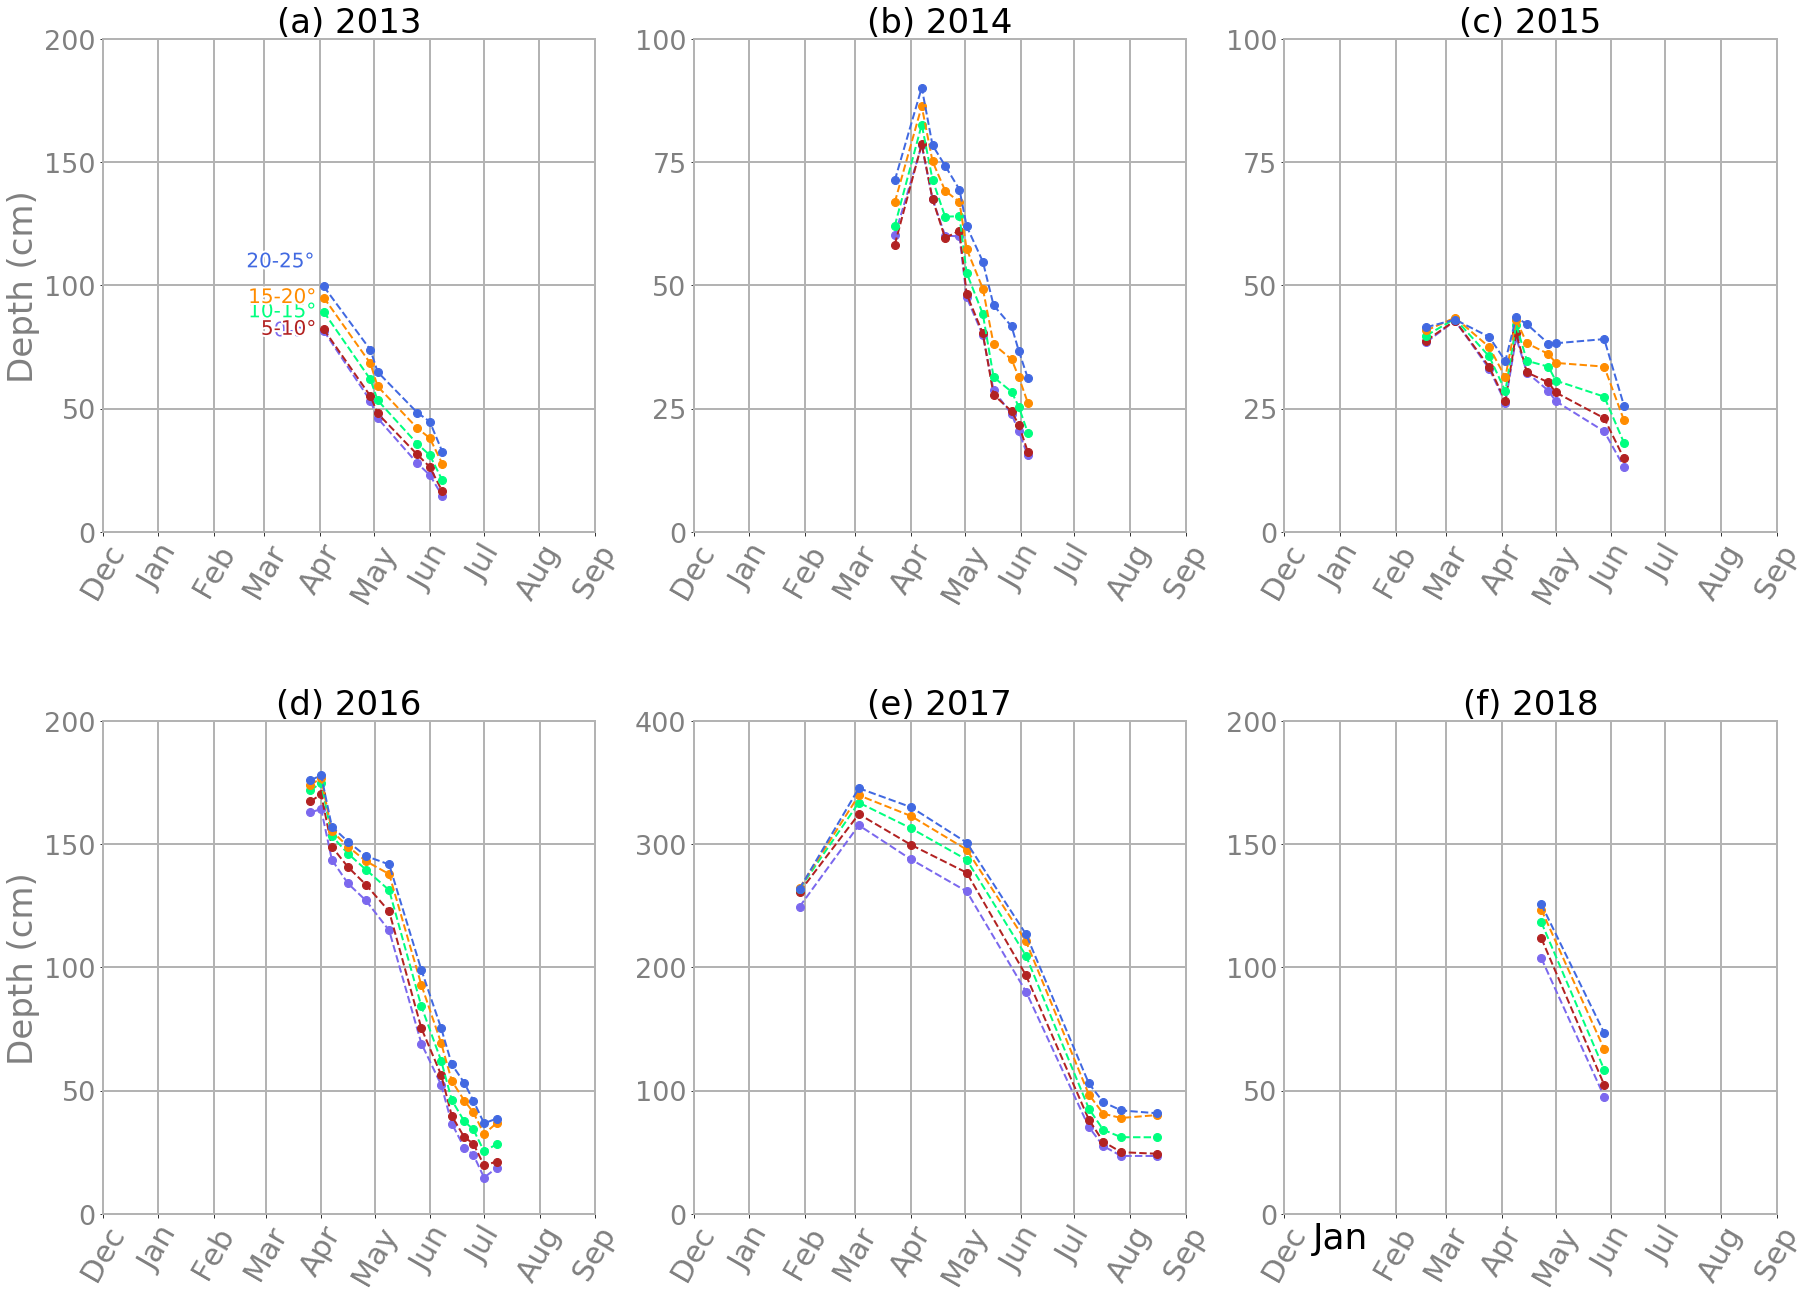

In [87]:
# plot mean snow depth at 10 degree slope bands

# area_250m_elev_bands = {lower_limit:0 for lower_limit in lower_limits}

#set up

fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

title_letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
marker = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x', '.', 'o', 'v', 'p', 'P', '*']
colors = ['b','g','r','c','m','y','b','lime','tan','sienna','mediumslateblue','firebrick','springgreen', 'darkorange','royalblue','hotpink']
# colors = [(175/255, 120/255, 30/255),
#           (255/255, 125/255, 1/255), 
#           (232/255, 21/255, 10/255),
#           (50/255, 50/255, 50/255),
#           (62/255, 160/255, 227/255)]

color_grey = 0.8
grey_text_intensity = 0.5
color_grey_grid = 0.7
color_taf = (color_grey, color_grey, color_grey)
color_grid = (color_grey_grid, color_grey_grid, color_grey_grid)
color_month = (color_grey, color_grey, color_grey)
color_grey_text = (grey_text_intensity, grey_text_intensity, grey_text_intensity)
letter_count = 0

# plt.figure(figsize = (24, 17))
plt.figure(figsize = (30, 23))
i_plot = 1

for year in depth_20m_years:
    
    ax = plt.subplot(2,3,i_plot)
    
    depth_plot = s_sd_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
    
    color_count = 10
    max_plot = 0
    
    for lower_limit in lower_limits[0:5]:#[3:-2]:
        
        color_band = colors[color_count]
        maker_band = marker[color_count]
        color_count += 1      
        
    
        plt.plot_date(depth_plot.index, depth_plot[lower_limit],
                      fmt='-', tz=None, xdate=True, ydate=False, label=int(lower_limit+band_width/2),
                      color = color_band, linestyle = '--', linewidth = '2', marker = 'o', 
                      markersize = 8, markerfacecolor = color_band)
        
        max_plot = max(max_plot, depth_plot[lower_limit].max())
        
        str_legend = str(int(lower_limit)) + '-' + str(int(lower_limit + band_width)) + '\u00B0'
        
    
        
        if year == 2013:
            
            if str_legend == '20-25'+'\u00B0': #different than ET's otherwise str_legend will overlap, +20 on y-axis
                 h_text = plt.text(depth_plot.index[0] - pd.Timedelta('5 days'), depth_plot[lower_limit][0] +10, str_legend, 
                                   color = color_band, fontsize = fs_legend-10,
                                   horizontalalignment = 'right', verticalalignment = 'center')
            else:
            
                h_text = plt.text(depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0], str_legend,
                                  color = color_band, fontsize = fs_legend-10, 
                                  horizontalalignment = 'right', verticalalignment = 'center')
                
            h_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        

    plt.title(title_letter[letter_count] + ' ' + str(year), fontsize = fs_titles)
    letter_count += 1

    if year in [2013, 2016]:
        plt.ylabel('Depth (cm)',fontsize = fs_labels+4, color = color_grey_text)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(fontsize = fs_axes, rotation = 60, horizontalalignment = 'center', color = color_grey_text)
    
    
        
    if year in [2014, 2015]:
        max_y = np.ceil(max_plot / 100) * 100
        
    else:
        max_y = np.ceil(max_plot / 200) * 200
        
           
    y_step = int(max_y / 4)
    y_ticks_marks = np.array(list(range(5))) * y_step
    y_ticks_labels = y_ticks_marks
    plt.ylim([25, max_y])
    plt.yticks(y_ticks_marks, y_ticks_labels.astype(int), fontsize = fs_axes-3, color = color_grey_text)
    plt.xlim([pd.to_datetime(str(year-1) + '-12-01'), pd.to_datetime(str(year) + '-09-01')])
    plt.grid(True)
    plt.grid(axis='both', color = color_grid, which = 'major', linestyle = '-', linewidth=2)
    
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['top'].set_color(color_grid)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['bottom'].set_color(color_grid)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['left'].set_color(color_grid)
    ax.spines['right'].set_linewidth(2.0)
    ax.spines['right'].set_color(color_grid)
    
    ratio = 1.0
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)        
        
    
    i_plot += 1
    
        
# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/elev_bands_subset_subplots.png', dpi=150) 

### veg (open and forest)

In [ ]:
#make open=0, forest=1

tease out some elevation bands....